In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2025-09-25 02:42:38.615189: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758768158.776731      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758768158.826632      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/source-based-news-classification/news_articles.csv


In [2]:
# --- 1. Load and Inspect Data ---
print("Loading data...")
try:
    df = pd.read_csv('/kaggle/input/source-based-news-classification/news_articles.csv')
except FileNotFoundError:
    print("Error: 'news_articles.csv' not found.")
    exit()

print("Initial data shape:", df.shape)

Loading data...
Initial data shape: (2096, 12)


In [3]:
# --- 2. Data Cleaning and Preprocessing ---
print("\nCleaning and preprocessing data for the Transformer model...")

# Drop rows where essential columns are missing
df.dropna(subset=['text', 'title', 'label'], inplace=True)

# Filter the DataFrame to only include 'Real' and 'Fake' news
df = df[df['label'].isin(['Real', 'Fake'])].copy()

# Map labels to numerical values
label_map = {'Real': 0, 'Fake': 1}
df['labels'] = df['label'].map(label_map)

# Combine title and text for the model input
df['input_text'] = df['title'] + " " + df['text']

print("Data shape after cleaning:", df.shape)
if df.empty or df['labels'].isnull().any():
    print("Error: No valid data or labels found after preprocessing. Exiting.")
    exit()


Cleaning and preprocessing data for the Transformer model...
Data shape after cleaning: (2050, 14)


In [4]:
# --- 3. Split Data and Prepare Datasets ---
print("\nSplitting data into training and testing sets...")

# We need to stratify to ensure both train and test sets have a similar distribution of labels.
train_df, test_df = train_test_split(
    df,
    test_size=0.25,
    random_state=42,
    stratify=df['label']
)

# Convert pandas DataFrames to Hugging Face Dataset objects
train_dataset = Dataset.from_pandas(train_df[['input_text', 'labels']])
test_dataset = Dataset.from_pandas(test_df[['input_text', 'labels']])

print(f"Training set size: {len(train_dataset)} samples")
print(f"Testing set size: {len(test_dataset)} samples")


Splitting data into training and testing sets...
Training set size: 1537 samples
Testing set size: 513 samples


In [5]:
# --- 4. Tokenization ---
print("\nTokenizing the text data...")
MODEL_NAME = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    # The tokenizer will pad and truncate the text to a fixed length
    return tokenizer(examples['input_text'], padding='max_length', truncation=True, max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


Tokenizing the text data...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/1537 [00:00<?, ? examples/s]

Map:   0%|          | 0/513 [00:00<?, ? examples/s]

In [6]:
# --- 5. Model Training ---
print("\nSetting up the Trainer...")
model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

# Define a function to compute metrics for evaluation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc}

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,  # Reduce if you face memory issues
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch", # Evaluate at the end of each epoch
    save_strategy="epoch",       # Save a checkpoint at the end of each epoch
    load_best_model_at_end=True, # Load the best model found during training
    report_to="none",            # <-- THIS LINE IS ADDED TO DISABLE WANDB
)

# Create the Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

print("Starting model training...")
trainer.train()
print("Model training complete.")


Setting up the Trainer...


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting model training...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.684400,0.603570,0.676413
2,0.498900,0.482291,0.746589
3,0.313500,0.528847,0.824561


Model training complete.



Evaluating the fine-tuned model...



Model Accuracy: 0.7466

Classification Report:
              precision    recall  f1-score   support

        Real       0.67      0.63      0.65       190
        Fake       0.79      0.81      0.80       323

    accuracy                           0.75       513
   macro avg       0.73      0.72      0.73       513
weighted avg       0.74      0.75      0.75       513


Confusion Matrix:
[[120  70]
 [ 60 263]]


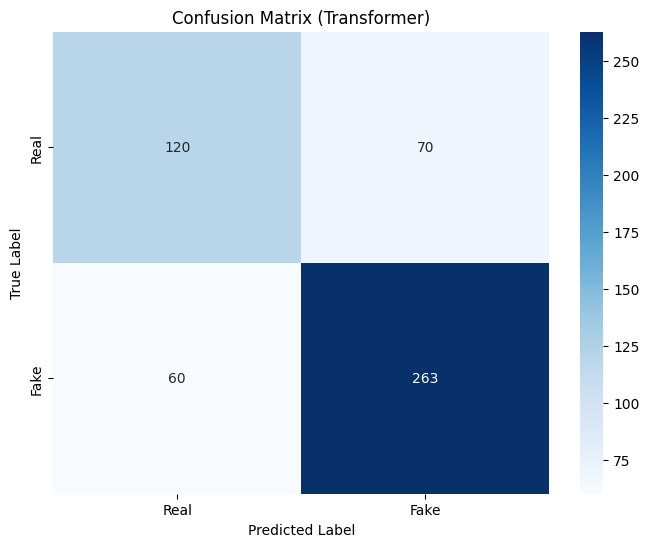

In [7]:
# --- 6. Model Evaluation ---
print("\nEvaluating the fine-tuned model...")

# Get predictions from the trainer
predictions_output = trainer.predict(test_dataset)
y_pred = np.argmax(predictions_output.predictions, axis=1)
y_true = test_dataset['labels']

# Calculate and print accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Real', 'Fake']))

# Print and visualize confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Transformer)')
plt.show()

In [8]:
# --- 7. Save Results ---
print("\nSaving prediction results to 'prediction_results_transformer.csv'...")

# Create a copy of the test dataframe to store results
results_df = test_df.copy()

# Map numeric predictions back to text labels ('Fake' for 1, 'Real' for 0)
inv_label_map = {v: k for k, v in label_map.items()}
results_df['pred_label'] = pd.Series(y_pred, index=results_df.index).map(inv_label_map)

# Get the list of original columns from the input file, excluding the original 'label'
original_input_cols = [
    'author', 'published', 'title', 'text', 'language', 'site_url',
    'main_img_url', 'type', 'title_without_stopwords',
    'text_without_stopwords', 'hasImage'
]

# Create the final list of columns for the output file
output_cols = [col for col in original_input_cols if col in results_df.columns] + ['pred_label']

# Select the desired columns and save to a new CSV file
output_df = results_df[output_cols]
output_df.to_csv('prediction_results_transformer.csv', index=False)

print("Results saved successfully to prediction_results_transformer.csv")


Saving prediction results to 'prediction_results_transformer.csv'...
Results saved successfully to prediction_results_transformer.csv
